<a href="https://colab.research.google.com/github/slancheros/RNN_NLP/blob/main/Microproyecto2_Entregable.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Técnicas de Deep Learning - Microproyecto 2 - RNN

Por: Sandra Lancheros y Pilar Muñoz.

# Objetivo General

Afianzar el conocimiento de las arquitecturas RNN en DeepLearning. Específicamente, vamos a utilizar una arquitectura RNN para predicción de Análisis de Sentimientos en clasificación binaria: Positivo o Negativo.

# Exploración y Perfilamiento de datos

Desarrollar un método basado en redes neuronales recurrentes que permita
clasificar con precisión las reseñas de películas en IMDb en una de las dos
categorías: positiva o negativa.
B. Conjunto de datos
- Los datos corresponden a un dataset de reseñas de películas en IMDb,
disponibles en el siguiente [enlace](https://www.kaggle.com/datasets/yasserh/imdb-movie-ratings-sentiment-analysis/data). El dataset contiene miles de reseñas
etiquetadas con su correspondiente rating y etiqueta de sentimiento (positivo o
negativo)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np

In [3]:
imdb_df = pd.read_csv('/content/drive/MyDrive/MasterIA/DeepLearning/Microproy2/movie.csv')

In [4]:
imdb_df

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1
...,...,...
39995,"""Western Union"" is something of a forgotten cl...",1
39996,This movie is an incredible piece of work. It ...,1
39997,My wife and I watched this movie because we pl...,0
39998,"When I first watched Flatliners, I was amazed....",1


In [5]:
imdb_df.shape

(40000, 2)

In [6]:
imdb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    40000 non-null  object
 1   label   40000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 625.1+ KB


In [7]:
imdb_df.describe()

,label
count,40000.000000
mean,0.499525
std,0.500006
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [8]:
etiquetas_unicas = imdb_df['label'].unique()
etiquetas_unicas

array([0, 1])

In [9]:
print(f"Cantidad de datos duplicados: {imdb_df.duplicated().sum()}")
print(f"Cantidad de datos nulos: {imdb_df.isnull().sum().sum()}")

Cantidad de datos duplicados: 277
Cantidad de datos nulos: 0


In [10]:
duplicated_rows = imdb_df[imdb_df.duplicated(keep='first')]
print(duplicated_rows)

                                                    text  label
2164   I find it rather useless to comment on this "m...      0
3236   An absolutely atrocious adaptation of the wond...      0
3428   When I first saw this film it was not an impre...      0
3652   Before I watched this tv movie I did not know ...      1
3787   What a clunker!<br /><br />It MUST have been m...      0
...                                                  ...    ...
39229  I Enjoyed Watching This Well Acted Movie Very ...      1
39246  You do realize that you've been watching the E...      0
39508  (Spoilers)<br /><br />Oh sure it's based on Mo...      0
39681  It's been a long time since I last saw a movie...      0
39746  Goodnight, Mister Tom begins in an impossibly ...      0

[277 rows x 2 columns]


In [11]:
imdb_df.drop_duplicates(inplace=True)

En la celda de abajo podemos ver que 277 registros han sido eliminados del dataset, dado que eran duplicados.

In [12]:
imdb_df.shape

(39723, 2)

En la siguiente celda vemos que los labels están bien distribuidos entre los grupos etiquetados como sentimiento positivo y negativo desde el data set original.

<Axes: title={'center': 'Distribución de etiquetas'}, xlabel='label'>

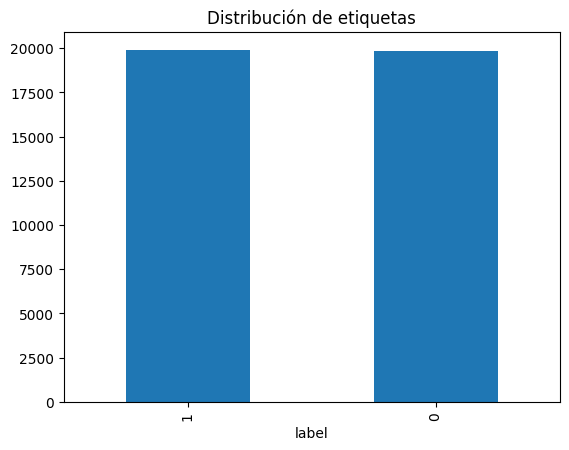

In [13]:
imdb_df.label.value_counts().plot(kind='bar', title='Distribución de etiquetas')

In [14]:
imdb_df.columns

Index(['text', 'label'], dtype='object')

# Análisis del Problema

### Objetivo

Desarrollar un método basado en redes neuronales recurrentes que permita
clasificar con precisión las reseñas de películas en IMDb en una de las dos
categorías: positiva o negativa.

### Actividades por realizar

1. **Preprocesamiento de las reseñas:** Construir un pipeline que permita limpiar y
tokenizar las reseñas de texto, convirtiéndolas en secuencias numéricas
utilizando embeddings (por ejemplo, Word2Vec o GloVe).

2. **Desarrollo de la arquitectura de red neuronal recurrente:** Implementar una
RNN (por ejemplo, LSTM o GRU) para la clasificación de las reseñas en dos
categorías. La arquitectura de la red es de libre elección, pero se sugiere incluir
capas de embedding, capas recurrentes y una capa densa de salida con
activación sigmoide. Justificar la elección de cada capa del modelo.

3. **Entrenamiento y evaluación del modelo:** Dividir el dataset en conjuntos de
entrenamiento, validación y prueba. Entrenar el modelo utilizando el conjunto de
entrenamiento y evaluar su rendimiento con el conjunto de prueba, reportando

# Preprocesamiento de  las reseñas

Vamos a utilizar Word2Vec como transformer y generar posteriormente un pipeline modular para trabajar con él.


In [15]:
#!pip install  nltk scikit-learn

In [16]:
!pip uninstall -y numpy
!pip install numpy==1.26.4 --force-reinstall

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.


In [17]:
!pip install gensim --force-reinstall

  Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.1 kB)
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached scipy-1.13.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Using cached smart_open-7.1.0-py3-none-any.whl.metadata (24 kB)
  Using cached wrapt-1.17.2-cp311-cp311-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.4 kB)
Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (26.7 MB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
Using cached scipy-1.13.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (38.6 MB)
Using cached smart_open-7.1.0-py3-none-any.whl (61 kB)
Using cached wrapt-1.17.2-cp311-cp311-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (83 kB)
  Att

In [18]:
import gensim.models.word2vec as w2v
import multiprocessing

In [19]:
import re
import string
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from gensim.models import KeyedVectors
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

# Clase de Preprocesamiento

In [20]:
class TextPreprocessor:
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        self.lemmatizer = WordNetLemmatizer()

    def preprocess(self, text):
        text = text.lower()
        text = re.sub(r'\d+', '', text)
        text = text.translate(str.maketrans('', '', string.punctuation))
        tokens = word_tokenize(text)
        tokens = [self.lemmatizer.lemmatize(t) for t in tokens if t not in self.stop_words]
        return tokens


# Tokenización y Vocabulario

In [21]:
class VocabBuilder():
    def __init__(self, min_freq=1):
        self.vocab = {'<PAD>': 0, '<UNK>': 1}

    def build(self, tokenized_texts):
        for tokens in tokenized_texts:
            for token in tokens:
                if token not in self.vocab:
                    self.vocab[token] = len(self.vocab)
        return self.vocab

    def encode(self, tokens, max_len):
        ids = [self.vocab.get(t, self.vocab['<UNK>']) for t in tokens]
        ids = ids[:max_len] + [self.vocab['<PAD>']] * max(0, max_len - len(ids))
        return ids

# Clase para crear los tensores para el dataset

In [22]:
class PrepareDataset(Dataset):
    def __init__(self, encoded_reviews, labels):
        self.X = torch.tensor(encoded_reviews, dtype=torch.long)
        self.y = torch.tensor(labels.tolist(), dtype=torch.float)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Crear la matriz de Embeddings

In [23]:
def build_embedding_matrix(w2v_model, vocab, embedding_dim):
    matrix = np.random.normal(scale=0.6, size=(len(vocab), embedding_dim))
    matrix[vocab['<PAD>']] = np.zeros(embedding_dim)
    for word, idx in vocab.items():
        if word in w2v_model:
            matrix[idx] = w2v_model[word]
    return torch.tensor(matrix, dtype=torch.float)


# Arquitectura RNN

### Justificación

En esta clase creamos una arquitectura RNN configurable. La arquitectura tiene las siguientes componentes:

1. Parámetros de la red:

*  **Un número de capas** que es configurable, pero por defecto tenemos una capa.
*  **La direccionalidad de la red** también va a ser configurable. Por defecto es unidireccional. Esto nos va a servir para comparar qué conviene más para el análisis de sentimiento con RNN.

* **El tipo de red RNN** es configurable y puede ser 'ltsm' o 'gru'. Esta configuración es configurable. Por defecto se utilizará ltsm y lo podremos cambiar dentro de las ablaciones para ver cuál nos conviene más para este caso de uso.

2. Tipos de capas:

Explicamos aquí los tipos de capas de la red, ya que van a ser configurables dentro de las ablaciones.

*   **Una capa de embedding** la cual es la entrada al modelo y en la cual podemos recibir por parámetro, ya que podemos utilizar un modelo pre-entrenado y sus embeddings en un tamaño específico
*   **Una serie de capas ocultas** cuya dimensión es configurable y esto nos servirá para configurarlo en nuestras ablaciones. El tipo de red y las dimensiones dependerán de los parámetros de la ablación en concreto.
* **Una capa de salida sigmoide** dado que el problema es de clasificación binaria, esta capa nos permitirá generar la respuesta (Positiva/Negativa)






---


| Acrónimo | Significado            |
| -------- | ---------------------- |
| **LSTM** | Long Short-Term Memory |
| **GRU**  | Gated Recurrent Unit   |




In [24]:
class SentimentRNN(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, num_layers=1, bidirectional=False, rnn_type='lstm'):
        super().__init__()
        num_embeddings, emb_dim = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=True)

        rnn_cls = nn.LSTM if rnn_type == 'lstm' else nn.GRU
        self.rnn = rnn_cls(
            input_size=emb_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional
        )

        direction_factor = 2 if bidirectional else 1
        self.fc = nn.Linear(hidden_dim * direction_factor, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        expected_input_dim = self.fc.in_features

        embedded = self.embedding(x)
        _, hidden = self.rnn(embedded)

        if isinstance(hidden, tuple):  # LSTM devuelve (hidden_state, cell_state)
            hidden = hidden[0]

        # Manejo correcto para RNN bidireccional y unidireccional
        if hidden.dim() == 3:
            if self.rnn.bidirectional and hidden.shape[0] >= 2:
                # Concatenamos la última capa forward y backward
                last_hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)
            else:
                last_hidden = hidden[-1]
        else:
            last_hidden = hidden.squeeze(0)

        # Validación final de dimensiones
        if last_hidden.shape[-1] != expected_input_dim:
            raise RuntimeError(
                f"La forma del hidden state no es compatible: recibida {last_hidden.shape[-1]}, esperada {expected_input_dim}. "
                f"Verificación de que hidden_dim es compatible para bidireccionalidad."
            )

        return self.sigmoid(self.fc(last_hidden)).squeeze(1)


    def extra_repr(self):
        return f"RNN(hidden_dim={self.rnn.hidden_size}, bidirectional={self.rnn.bidirectional})"



# Clase que representa el Pipeline para Análisis de Sentimiento

Vamos a utilizar Optuna para encontrar los mejores hiperparámetros para la red y el modelo. Por otra parte, en este pipeline podemos cargar flexiblemente el modelo preentrenado.

In [25]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 25.6 MB/s eta 0:00:00


In [26]:
import optuna

In [27]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

In [28]:
import matplotlib.pyplot as plt

In [29]:
import matplotlib.ticker as mtick

In [30]:
from tqdm import tqdm

In [31]:
import nltk

In [32]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [33]:
class SentimentPipeline:
    def __init__(self, w2v_model, embedding_dim=300, max_len=50, search_space=None, default_archs=None, default_hparams=None):
      self.preprocessor = TextPreprocessor()
      self.tokenizer = VocabBuilder()
      self.max_len = max_len
      self.embedding_dim = embedding_dim
      self.w2v = w2v_model
      self.model = None
      self.vocab = None
      self.search_space = search_space
      self.default_archs = default_archs
      self.default_hparams = default_hparams
      self.study = None
      self.best_params = None
      self.best_score = None
      self.best_model = None
      self.results = []
      self.best_result = None

        # Espacio de búsqueda de hiperparámetros (por defecto)
      self.search_space = search_space or {
          "hidden_dim": (32, 128),
          "lr": (1e-4, 1e-2),
          "freeze": [True, False]
      }

      # Arquitecturas por defecto para ablación
      self.default_archs = default_archs or [
          {"rnn_type": "gru", "num_layers": 1, "bidirectional": False},
          {"rnn_type": "gru", "num_layers": 2, "bidirectional": True},
          {"rnn_type": "lstm", "num_layers": 1, "bidirectional": False}
      ]

      # Hiperparámetros fijos por defecto
      self.default_hparams = default_hparams or {
          "n_trials": 5,
          "epochs": 3,
          "batch_size": 4
      }
      return None

    def preprocess_and_tokenize(self, df, build_vocab=True):
        df['tokens'] = df['text'].apply(self.preprocessor.preprocess)
        if build_vocab:
            self.vocab = self.tokenizer.build(df['tokens'])
        df['encoded'] = df['tokens'].apply(lambda x: self.tokenizer.encode(x, self.max_len))
        return df

    def create_dataset(self, df):
      return PrepareDataset(df['encoded'].tolist(), df['label'])

    def train_test_split(self, df, test_size=0.2):
      return train_test_split(df, test_size=test_size, stratify=df['label'], random_state=42)



    def evaluate(self, dataset, device=None):
      device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
      print(f"Evaluating on device: {device}")
      dataloader = DataLoader(dataset, batch_size=2)
      self.model.eval()
      all_preds = []
      all_labels = []
      with torch.no_grad():
          for X_batch, y_batch in dataloader:
              X_batch = X_batch.to(device)
              y_batch = y_batch.to(device)
              preds = self.model(X_batch)
              predicted = (preds >= 0.5).float()
              all_preds.extend(predicted.tolist())
              all_labels.extend(y_batch.tolist())

      acc = accuracy_score(all_labels, all_preds)
      prec = precision_score(all_labels, all_preds)
      rec = recall_score(all_labels, all_preds)
      f1 = f1_score(all_labels, all_preds)

      print(f"Accuracy:  {acc:.2f}")
      print(f"Precision: {prec:.2f}")
      print(f"Recall:    {rec:.2f}")
      print(f"F1-score:  {f1:.2f}")

      return {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1}

    def train(self, dataset, hidden_dim=64, lr=0.001, freeze=True, epochs=5,
          num_layers=1, bidirectional=False, rnn_type='lstm', batch_size=2, device=None):
      device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
      print(f"Training on device: {device}")

      # Ajustar hidden_dim si es necesario
      if bidirectional and hidden_dim % 2 != 0:
          print(f"Ajustando hidden_dim de {hidden_dim} to {hidden_dim + 1} para compatibilidad bidireccional.")
          hidden_dim += 1

      dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
      embedding_matrix = build_embedding_matrix(self.w2v, self.vocab, self.embedding_dim)

      self.model = SentimentRNN(
          embedding_matrix,
          hidden_dim=hidden_dim,
          num_layers=num_layers,
          bidirectional=bidirectional,
          rnn_type=rnn_type
      ).to(device)

      self.model.embedding.weight.requires_grad = not freeze

      criterion = nn.BCELoss()
      optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)

      self.model.train()
      for epoch in range(epochs):
          total_loss = 0
          correct = 0
          for X_batch, y_batch in dataloader:
              X_batch, y_batch = X_batch.to(device), y_batch.to(device)
              optimizer.zero_grad()
              preds = self.model(X_batch)
              loss = criterion(preds, y_batch)
              loss.backward()
              optimizer.step()

              total_loss += loss.item()
              correct += ((preds >= 0.5).float() == y_batch).sum().item()

          acc = correct / len(dataset)
          print(f"Epoch {epoch+1} | Loss: {total_loss:.4f} | Accuracy: {acc:.2f}")
      return self.model


    def evaluate_model(self, model, dataset, batch_size):
      dataloader = DataLoader(dataset, batch_size=batch_size)
      model.eval()
      all_preds, all_labels = [], []
      with torch.no_grad():
          for X_batch, y_batch in dataloader:
              preds = model(X_batch)
              predicted = (preds >= 0.5).float()
              all_preds.extend(predicted.tolist())
              all_labels.extend(y_batch.tolist())
      f1 = f1_score(all_labels, all_preds)
      return f1

    def predict(self, text, device=None):
        device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Predicting on device: {device}")
        tokens = self.preprocessor.preprocess(text)
        encoded = self.tokenizer.encode(tokens, self.max_len)
        input_tensor = torch.tensor([encoded], dtype=torch.long).to(device)
        self.model.eval()
        with torch.no_grad():
            output = self.model(input_tensor)
        return "Positive" if output.item() >= 0.5 else "Negative"

    def optimize(self, df, n_trials=10):
        df_train, df_val = self.train_test_split(df)
        df_train = self.preprocess_and_tokenize(df_train, build_vocab=True)
        df_val = self.preprocess_and_tokenize(df_val, build_vocab=False)
        train_dataset = self.create_dataset(df_train)
        val_dataset = self.create_dataset(df_val)

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        def objective(trial):
            hidden_dim = trial.suggest_int("hidden_dim", 64, 128)
            lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
            freeze = trial.suggest_categorical("freeze", [True, False])
            rnn_type = trial.suggest_categorical("rnn_type", ["gru", "lstm"])
            num_layers = trial.suggest_int("num_layers", 1, 2)
            bidirectional = trial.suggest_categorical("bidirectional", [True, False])

            # Ajuste de hidden_dim si es necesario
            if bidirectional and hidden_dim % 2 != 0:
                hidden_dim += 1

            self.train(
                train_dataset,
                hidden_dim=hidden_dim,
                lr=lr,
                freeze=freeze,
                epochs=3,
                num_layers=num_layers,
                bidirectional=bidirectional,
                rnn_type=rnn_type,
                batch_size=4,
                device=device
            )
            metrics = self.evaluate(val_dataset, device=device)
            return metrics["f1"]

        study = optuna.create_study(direction="maximize")
        study.optimize(objective, n_trials=n_trials)
        print("Mejores hiperparámetros:", study.best_params)
        return study.best_params


    def run_ablation(self, df, configs, visualize=False, parallel=False):
        import concurrent.futures
        from functools import partial

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        df_train, df_val = self.train_test_split(df)
        df_train = self.preprocess_and_tokenize(df_train, build_vocab=True)
        df_val = self.preprocess_and_tokenize(df_val, build_vocab=False)
        train_dataset = self.create_dataset(df_train)
        val_dataset = self.create_dataset(df_val)

        def run_config(config):
            print(f"\nProbando Configuración: {config}")
            self.train(
                train_dataset,
                hidden_dim=self.search_space.get("hidden_dim", 64),
                lr=self.default_hparams.get("lr", 0.001),
                freeze=self.default_hparams.get("freeze", True),
                epochs=self.default_hparams.get("epochs", 5),
                num_layers=config.get("num_layers", 1),
                bidirectional=config.get("bidirectional", False),
                rnn_type=config.get("rnn_type", "lstm"),
                device=device
            )
            metrics = self.evaluate(val_dataset, device=device)
            return {"config": config, **metrics}

        if parallel:
            with concurrent.futures.ProcessPoolExecutor() as executor:
                results = list(tqdm(executor.map(partial(run_config), configs), total=len(configs), desc="Corriendo ablación en paralelo"))
        else:
            results = [run_config(config) for config in tqdm(configs, desc="Corriendo Ablación")]

        results = sorted(results, key=lambda r: r['f1'], reverse=True)

        if visualize:
            self.visualize_results(results)

        return results


    def visualize_results(self, results):
        import matplotlib.pyplot as plt
        import matplotlib.ticker as mtick

        if not results:
            print("No hay resultados para visualizar.")
            return

        df = pd.DataFrame(results)
        #df['label'] = df['architecture'].apply(lambda x: f"{x['rnn_type']}-{x['num_layers']}x{'bi' if x['bidirectional'] else 'uni'}")
        df = df.sort_values(by="f1", ascending=False)

        plt.figure(figsize=(10, 5))
        bars = plt.bar(df['label'], df['f1'], color='skyblue')
        plt.title("F1-score por arquitectura optimizada")
        plt.ylabel("F1-score")
        plt.ylim(0, 1)
        plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
        plt.xticks(rotation=45)

        for bar, f1 in zip(bars, df['f1']):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f"{f1:.2f}", ha='center', va='bottom')

        plt.tight_layout()
        plt.show()

    def optimize_from_ablation(self, df, ablated_archs, n_trials=5, epochs=3, save_path=None, batch_size=2):
        import time
        if not hasattr(self.w2v, '__contains__'):
            raise TypeError("El modelo de embeddings proporcionado no es válido. Asegúrate de usar api.load(...) y no el módulo gensim.downloader.")

        df_train, df_val = self.train_test_split(df)
        df_train = self.preprocess_and_tokenize(df_train, build_vocab=True)
        df_val = self.preprocess_and_tokenize(df_val, build_vocab=False)
        train_dataset = self.create_dataset(df_train)
        val_dataset = self.create_dataset(df_val)

        all_results = []

        for arch in tqdm(ablated_archs, desc="Architectures"):
            print(f"\nOptimizing for architecture: {arch}")

            def objective(trial):
                hidden_dim = trial.suggest_int("hidden_dim", 32, 128)
                lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
                freeze = trial.suggest_categorical("freeze", [True, False])

                model = self.train_model(
                    train_dataset,
                    hidden_dim=hidden_dim,
                    lr=lr,
                    freeze=freeze,
                    epochs=epochs,
                    num_layers=arch["num_layers"],
                    bidirectional=arch["bidirectional"],
                    rnn_type=arch["rnn_type"],
                    batch_size=batch_size
                )
                f1 = self.evaluate_model(model, val_dataset, batch_size=batch_size)
                return f1

            start_time = time.time()
            study = optuna.create_study(direction="maximize")
            study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
            elapsed_time = time.time() - start_time

            best_params = study.best_params
            best_score = study.best_value

            result = {
               # "architecture": arch,
                **best_params,
                "f1": best_score,
                "time_sec": round(elapsed_time, 2)
            }
            all_results.append(result)
            print(f"Mejor resultado para la arquitectura {arch}: {result}")

        if save_path:
            pd.DataFrame(all_results).to_csv(save_path, index=False)
            print(f"Resultados guardados en: {save_path}")

        return all_results

    def visualize_ablation_results(self,results):

      if not results:
          print("No hay resultados para visualizar.")
          return

      df = pd.DataFrame(results)
      df['label'] = df['config'].apply(lambda cfg: f"{cfg.get('rnn_type', '')}-{cfg.get('num_layers', '')}x{'bi' if cfg.get('bidirectional', False) else 'uni'}")

      df = df.sort_values(by="f1", ascending=False)

      plt.figure(figsize=(10, 5))
      bars = plt.bar(df['label'], df['f1'], color='skyblue')
      plt.title("F1-score por configuración (ablation)")
      plt.ylabel("F1-score")
      plt.ylim(0, 1)
      plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
      plt.xticks(rotation=45)

      for bar, f1 in zip(bars, df['f1']):
          plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f"{f1:.2f}", ha='center', va='bottom')

      plt.tight_layout()
      plt.show()

    def run_and_compare(self, df, configs, epochs=3, batch_size=4):
        """
        Ejecuta el pipeline para cada configuración y guarda métricas.
        """
        df_train, df_val = self.train_test_split(df)
        df_train = self.preprocess_and_tokenize(df_train, build_vocab=True)
        df_val = self.preprocess_and_tokenize(df_val, build_vocab=False)
        train_dataset = self.create_dataset(df_train)
        val_dataset = self.create_dataset(df_val)

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Running on device: {device}")

        results = []
        best_score = -1
        best_model = None
        best_config = None

        for cfg in configs:
            print(f"\nProbando configuración: {cfg}")
            hidden_dim = cfg.get("hidden_dim", 64)

            if cfg.get("bidirectional") and hidden_dim % 2 != 0:
                print(f"hidden_dim ajustado de {hidden_dim} a {hidden_dim + 1}")
                hidden_dim += 1

            self.train(
                train_dataset,
                hidden_dim=hidden_dim,
                lr=cfg.get("lr", 0.001),
                freeze=cfg.get("freeze", True),
                epochs=epochs,
                num_layers=cfg.get("num_layers", 1),
                bidirectional=cfg.get("bidirectional", False),
                rnn_type=cfg.get("rnn_type", "lstm"),
                batch_size=batch_size,
                device=device
            )

            metrics = self.evaluate(val_dataset, device=device)
            metrics["config"] = cfg
            results.append(metrics)

            if metrics["f1"] > best_score:
                best_score = metrics["f1"]
                best_model = self.model
                best_config = cfg

        self.plot_comparison(results)

        return {
            "results": results,
            "best_model": best_model,
            "best_config": best_config
        }

    def evaluate_with_confusion(self, dataset, device=None):
      device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
      print(f"Evaluating on device: {device}")

      dataloader = DataLoader(dataset, batch_size=2)
      self.model.eval()
      all_preds = []
      all_labels = []

      with torch.no_grad():
          for X_batch, y_batch in dataloader:
              X_batch, y_batch = X_batch.to(device), y_batch.to(device)
              preds = self.model(X_batch)
              predicted = (preds >= 0.5).float()
              all_preds.extend(predicted.cpu().numpy())
              all_labels.extend(y_batch.cpu().numpy())

      print(classification_report(all_labels, all_preds))
      cm = confusion_matrix(all_labels, all_preds)
      disp = ConfusionMatrixDisplay(confusion_matrix=cm)
      disp.plot()

    def plot_comparison(self, results):
        import matplotlib.pyplot as plt
        import pandas as pd

        if not results:
            print("No hay resultados para graficar.")
            return

        # Convertir resultados a DataFrame
        df = pd.DataFrame(results)
        df["config_str"] = df["config"].apply(
            lambda cfg: f"{cfg['rnn_type']}-{cfg['num_layers']}x{'bi' if cfg['bidirectional'] else 'uni'}"
        )

        metrics = ["accuracy", "f1", "recall", "precision"]
        x_labels = df["config_str"]
        x = range(len(x_labels))
        width = 0.2

        plt.figure(figsize=(12, 6))
        for i, metric in enumerate(metrics):
            values = df[metric]
            bar_positions = [p + i * width for p in x]
            plt.bar(bar_positions, values, width=width, label=metric)

        plt.xticks([p + width * 1.5 for p in x], x_labels, rotation=45)
        plt.ylabel("Score")
        plt.ylim(0, 1.05)
        plt.title("Comparación de métricas por arquitectura")
        plt.legend()
        plt.grid(axis='y', linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()

        # Guardar como atributo del pipeline
        self.last_comparison_df = df




# Entrenamiento del modelo con el Pipeline

In [34]:
df = imdb_df.copy()

Bajamos el modelo pre-entrenado de glove para agregar nuestro entrenamiento posteriormente.

In [35]:
import gensim.downloader as api
w2v= api.load("glove-wiki-gigaword-100")  # ~130 MB

[==================================================] 100.0% 128.1/128.1MB downloaded


Utilizamos el modelo Glove para utilizar con 100 dimensiones de embedding (esto va en nuestros parámetros del pipeline). Dado que encontrar los mejores parámetros con optuna nos está tardando demasiado, vamos hacer dos "trials". Con estos esperamos optimizar los hiperparámetros y Hemos equipado al pipeline con un método para correr la ablación, el cual estaremos utilizando más adelante.

In [36]:
# 1. Inicializar pipeline
pipeline = SentimentPipeline(w2v_model=w2v, embedding_dim=100, max_len=50)

# 2. Buscar mejores hiperparámetros
best_params = pipeline.optimize(df, n_trials=2)



[I 2025-05-13 11:37:25,905] A new study created in memory with name: no-name-4fe41a2d-b69c-41e6-9b1d-30361e162e6c


Training on device: cuda
Epoch 1 | Loss: 3375.3602 | Accuracy: 0.80
Epoch 2 | Loss: 1681.8996 | Accuracy: 0.92
Epoch 3 | Loss: 544.4200 | Accuracy: 0.98
Evaluating on device: cuda


[I 2025-05-13 11:40:25,239] Trial 0 finished with value: 0.8155219439623109 and parameters: {'hidden_dim': 113, 'lr': 0.0011521998363690483, 'freeze': False, 'rnn_type': 'gru', 'num_layers': 2, 'bidirectional': True}. Best is trial 0 with value: 0.8155219439623109.


Accuracy:  0.81
Precision: 0.81
Recall:    0.83
F1-score:  0.82
Training on device: cuda
Epoch 1 | Loss: 3446.9493 | Accuracy: 0.80
Epoch 2 | Loss: 1940.8486 | Accuracy: 0.90
Epoch 3 | Loss: 908.4171 | Accuracy: 0.96
Evaluating on device: cuda


[I 2025-05-13 11:42:58,618] Trial 1 finished with value: 0.82574184882159 and parameters: {'hidden_dim': 74, 'lr': 0.0006205974133218978, 'freeze': False, 'rnn_type': 'gru', 'num_layers': 1, 'bidirectional': True}. Best is trial 1 with value: 0.82574184882159.


Accuracy:  0.82
Precision: 0.80
Recall:    0.85
F1-score:  0.83
Mejores hiperparámetros: {'hidden_dim': 74, 'lr': 0.0006205974133218978, 'freeze': False, 'rnn_type': 'gru', 'num_layers': 1, 'bidirectional': True}


Aunque en cada ejecución hemos visto que los "trials" ejecutan parámetros diferentes, quisimos guardar esta ejecución que funcionó particularmente bien al primer intento:


```
[I 2025-05-13 11:37:25,905] A new study created in memory with name: no-name-4fe41a2d-b69c-41e6-9b1d-30361e162e6c
Training on device: cuda
Epoch 1 | Loss: 3375.3602 | Accuracy: 0.80
Epoch 2 | Loss: 1681.8996 | Accuracy: 0.92
Epoch 3 | Loss: 544.4200 | Accuracy: 0.98
Evaluating on device: cuda
[I 2025-05-13 11:40:25,239] Trial 0 finished with value: 0.8155219439623109 and parameters: {'hidden_dim': 113, 'lr': 0.0011521998363690483, 'freeze': False, 'rnn_type': 'gru', 'num_layers': 2, 'bidirectional': True}. Best is trial 0 with value: 0.8155219439623109.
Accuracy:  0.81
Precision: 0.81
Recall:    0.83
F1-score:  0.82
```



En estas celdas entrenamos el modelo con los mejores parámetros encontrados.

In [37]:
# 3. Preprocesar, codificar y crear dataset
df = pipeline.preprocess_and_tokenize(df)
dataset = pipeline.create_dataset(df)

# 4. Entrenar modelo con mejores parámetros
pipeline.train(
    dataset,
    hidden_dim=best_params["hidden_dim"],
    lr=best_params["lr"],
    num_layers=best_params["num_layers"],
    bidirectional=best_params["bidirectional"],
    rnn_type=best_params["rnn_type"],
    freeze=best_params["freeze"],
    epochs=5
)

# 5. Evaluar el modelo
pipeline.evaluate(dataset)

# 6. Probar con nuevo texto
print(pipeline.predict("This was a wonderful film with great characters"))
print(pipeline.predict("Awful movie, I couldn't even finish it"))

Training on device: cuda
Epoch 1 | Loss: 8184.5340 | Accuracy: 0.81
Epoch 2 | Loss: 4780.7636 | Accuracy: 0.90
Epoch 3 | Loss: 2353.7294 | Accuracy: 0.96
Epoch 4 | Loss: 761.5765 | Accuracy: 0.99
Epoch 5 | Loss: 175.0710 | Accuracy: 1.00
Evaluating on device: cuda
Accuracy:  1.00
Precision: 1.00
Recall:    1.00
F1-score:  1.00
Predicting on device: cuda
Positive
Predicting on device: cuda
Negative


Vemos que con los mejores hiper parámetros encontrados por optuna hemos logrado unas métricas buenas. Sin embargo vamos a intentar optimizar por medio de la ablación. Para esto vamos a generar una función para optimizar con respecto a esta ablación.

Guardamos el mejor modelo aquí para poder utilizarlo después si

In [38]:
mejor_modelo = pipeline.model

Evaluating on device: cuda
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     19815
         1.0       1.00      1.00      1.00     19908

    accuracy                           1.00     39723
   macro avg       1.00      1.00      1.00     39723
weighted avg       1.00      1.00      1.00     39723



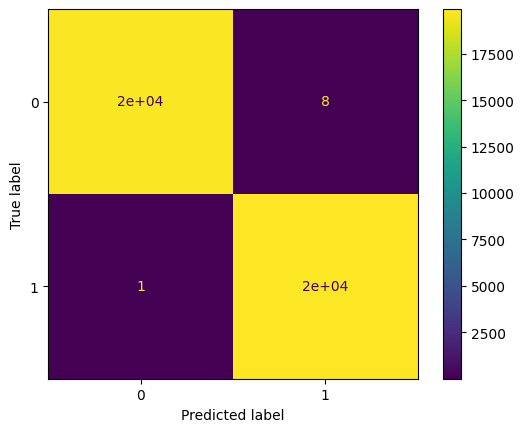

In [40]:
pipeline.evaluate_with_confusion(dataset)

Vemos que este modelo tiene un muy buen rendimiento sobre el dataset. Podemos utilizar este modelo para predecir cualquier nuevo texto para clasificarlo como Positivo o Negativo.

### Celdas auxiiliares para revisar que la clase ha sido bien definida

In [44]:
df = imdb_df.copy()

In [45]:
method_list = [func for func in dir(SentimentPipeline) if callable(getattr(SentimentPipeline, func))]

In [46]:
method_list

['__class__',
 '__delattr__',
 '__dir__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'create_dataset',
 'evaluate',
 'evaluate_model',
 'evaluate_with_confusion',
 'optimize',
 'optimize_from_ablation',
 'plot_comparison',
 'predict',
 'preprocess_and_tokenize',
 'run_ablation',
 'run_and_compare',
 'train',
 'train_test_split',
 'visualize_ablation_results',
 'visualize_results']

A pesar de que Optuna nos ha ayudado a encontrar el mejor modelo, este pipeline también nos permite explorar otras arquitecturas pasando la configuración como parámetro y dando un search space para encontrar los parámetros para esta configuración.

# Ablaciones - Utilización del pipeline

# Arquitectura 1 - GRU - 1 layer - unidirectional - hidden dimmensions

In [47]:
search_space = {
    "hidden_dim": best_params['hidden_dim'],
    "lr": best_params['lr'],
    "freeze": best_params['freeze']
}

ablated_archs = [
        {"rnn_type": "gru", "num_layers": 1, "bidirectional": False},
    ]

pipeline = SentimentPipeline(
    w2v_model=w2v,
    embedding_dim=100,
    search_space=search_space,
    default_archs=ablated_archs,
    default_hparams={"n_trials": 2, "epochs": 5, "batch_size": 4}
)

results = pipeline.run_ablation(df,configs=ablated_archs)  # usa todo lo parametrizado


Running Ablation:   0%|          | 0/1 [00:00<?, ?it/s]


Testing config: {'rnn_type': 'gru', 'num_layers': 1, 'bidirectional': False}
Training on device: cuda
Epoch 1 | Loss: 7673.0002 | Accuracy: 0.76
Epoch 2 | Loss: 6359.6145 | Accuracy: 0.82
Epoch 3 | Loss: 5587.1334 | Accuracy: 0.84
Epoch 4 | Loss: 4800.1816 | Accuracy: 0.87
Epoch 5 | Loss: 3994.0715 | Accuracy: 0.89
Evaluating on device: cuda


Running Ablation: 100%|██████████| 1/1 [03:05<00:00, 185.31s/it]

Accuracy:  0.80
Precision: 0.77
Recall:    0.86
F1-score:  0.81


In [48]:
model1 = pipeline.model

In [49]:
model1

SentimentRNN(
  RNN(hidden_dim=74, bidirectional=False)
  (embedding): Embedding(128180, 100)
  (rnn): GRU(100, 74, batch_first=True)
  (fc): Linear(in_features=74, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [50]:
print("\nResumen de resultados:")
for r in results:
    print(r)


Resumen de resultados:
{'config': {'rnn_type': 'gru', 'num_layers': 1, 'bidirectional': False}, 'accuracy': 0.7991189427312775, 'precision': 0.7657015590200446, 'recall': 0.8633852335509794, 'f1': 0.8116147308781869}


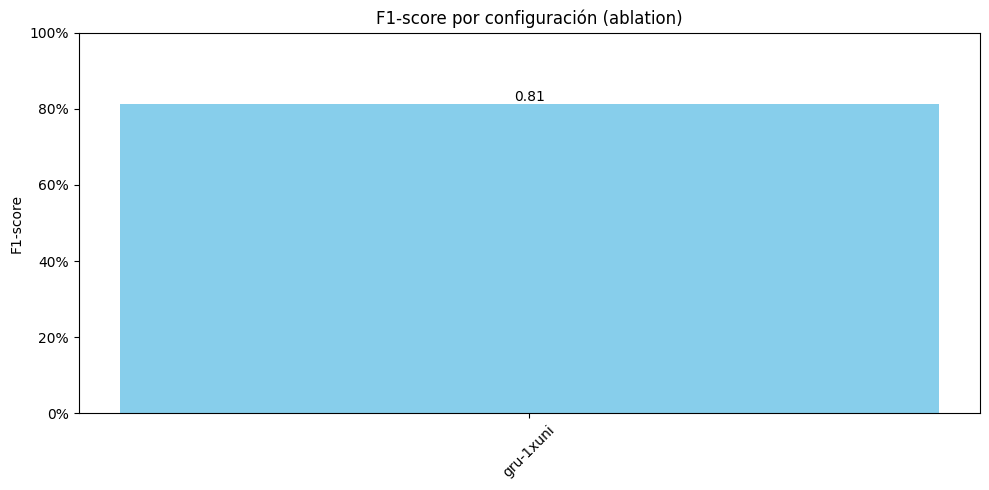

In [51]:
pipeline.visualize_ablation_results(results)

In [52]:
#pipeline.model = pipeline.best_model  # o el que quieras evaluar

df_val = pipeline.preprocess_and_tokenize(df, build_vocab=False)
val_dataset = pipeline.create_dataset(df_val)



Evaluating on device: cuda
              precision    recall  f1-score   support

         0.0       0.94      0.85      0.89     19815
         1.0       0.86      0.95      0.90     19908

    accuracy                           0.90     39723
   macro avg       0.90      0.90      0.90     39723
weighted avg       0.90      0.90      0.90     39723



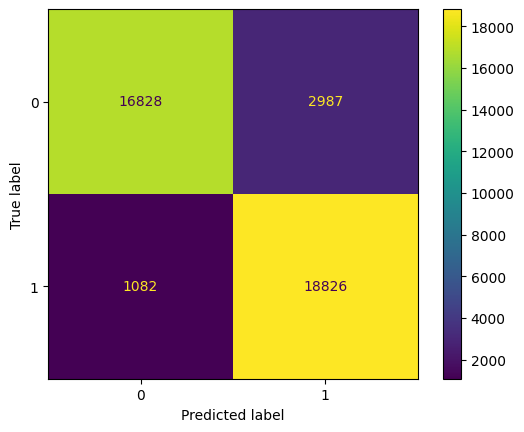

In [53]:
pipeline.evaluate_with_confusion(val_dataset)

In [54]:
pipeline.best_model = model1

# Arquitectura 2 - GRU - 2 layers - Bidirectional  (68 hidden- units)

In [55]:
ablated_archs = [
        {"rnn_type": "gru", "num_layers": 2, "bidirectional": True},
    ]


En esta ablación colocamos las dimensiones manualmente dado que hubo problemas al tener un número de unidades impar. Seleccionamos 68, dado que fue uno de los valores que encontramos en una de las iteraciones de optimización anteriormente. Cabe anotar que **cada vez que se corren las iteraciones de optimización, las unidades pueden cambiar, por lo que estos parámetros no son fijos** seleccionamos 68 sólo para colocar un valor que pueda funcionar en la ablación.

In [56]:
search_space = {
    "hidden_dim": 68,
    #"hidden_dim": best_params['hidden_dim'],
    "lr": best_params['lr'],
    "freeze": best_params['freeze']
}

In [57]:
pipeline = SentimentPipeline(
    w2v_model=w2v,
    embedding_dim=100,
    search_space=search_space,
    default_archs=ablated_archs,
    default_hparams={"n_trials": 2, "epochs": 5, "batch_size": 4}
)

results_2 = pipeline.run_ablation(df,configs=ablated_archs)


Running Ablation:   0%|          | 0/1 [00:00<?, ?it/s]


Testing config: {'rnn_type': 'gru', 'num_layers': 2, 'bidirectional': True}
Training on device: cuda
Epoch 1 | Loss: 7533.5185 | Accuracy: 0.77
Epoch 2 | Loss: 6304.4699 | Accuracy: 0.82
Epoch 3 | Loss: 5344.4058 | Accuracy: 0.85
Epoch 4 | Loss: 4264.3562 | Accuracy: 0.89
Epoch 5 | Loss: 3225.7016 | Accuracy: 0.92
Evaluating on device: cuda


Running Ablation: 100%|██████████| 1/1 [04:57<00:00, 298.00s/it]

Accuracy:  0.80
Precision: 0.81
Recall:    0.80
F1-score:  0.80


In [58]:
model2 = pipeline.model

In [60]:
model2

SentimentRNN(
  RNN(hidden_dim=68, bidirectional=True)
  (embedding): Embedding(128180, 100)
  (rnn): GRU(100, 68, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=136, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [59]:
print("\nResumen de resultados 3ra arquitectura:")
for r in results_2:
    print(r)


Resumen de resultados 3ra arquitectura:
{'config': {'rnn_type': 'gru', 'num_layers': 2, 'bidirectional': True}, 'accuracy': 0.8042794210195091, 'precision': 0.8066717210007581, 'recall': 0.801607232546459, 'f1': 0.8041315027081496}


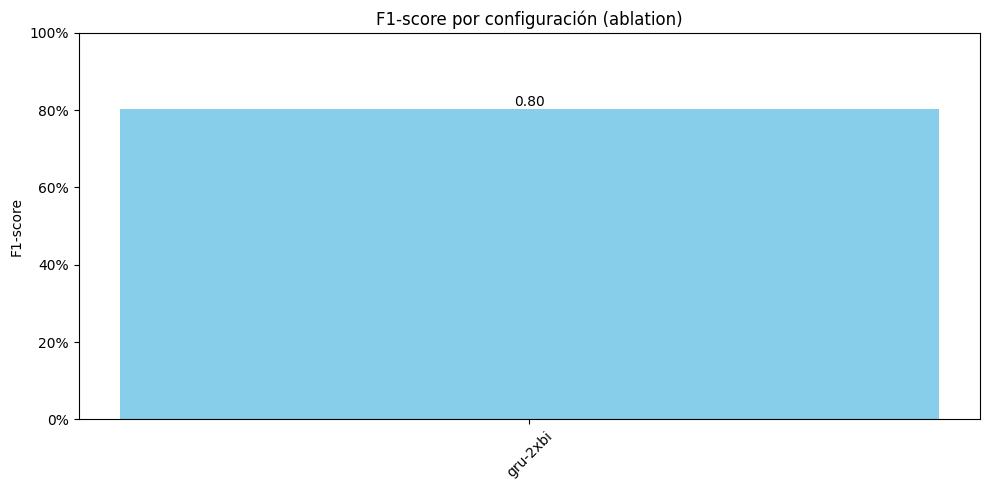

In [61]:
pipeline.visualize_ablation_results(results_2)

Evaluating on device: cuda
              precision    recall  f1-score   support

         0.0       0.92      0.94      0.93     19815
         1.0       0.94      0.92      0.93     19908

    accuracy                           0.93     39723
   macro avg       0.93      0.93      0.93     39723
weighted avg       0.93      0.93      0.93     39723



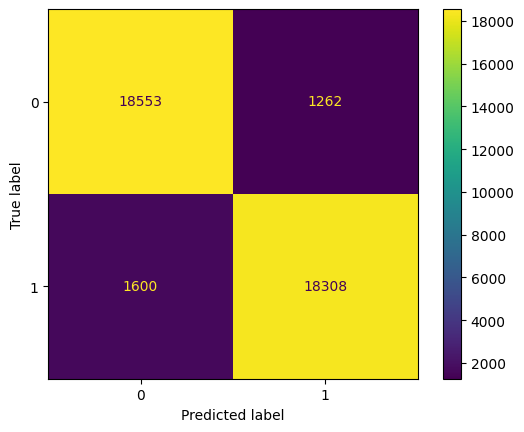

In [62]:
pipeline.evaluate_with_confusion(val_dataset)

# Arquitectura 3 : LSTM - 1 layer - Unidirectional -  Optimal Hidden Units

In [63]:
search_space = {
    "hidden_dim": best_params['hidden_dim'],
    "lr": best_params['lr'],
    "freeze": best_params['freeze']
}

In [64]:
ablated_archs = [
        {"rnn_type": "lstm", "num_layers": 1, "bidirectional": False},
    ]


In [65]:
pipeline = SentimentPipeline(
    w2v_model=w2v,
    embedding_dim=100,
    search_space=search_space,
    default_archs=ablated_archs,
    default_hparams={"n_trials": 2, "epochs": 5, "batch_size": 4}
)

results_3 = pipeline.run_ablation(df,configs=ablated_archs)  # usa todo lo parametrizado


Running Ablation:   0%|          | 0/1 [00:00<?, ?it/s]


Testing config: {'rnn_type': 'lstm', 'num_layers': 1, 'bidirectional': False}
Training on device: cuda
Epoch 1 | Loss: 8350.1869 | Accuracy: 0.72
Epoch 2 | Loss: 6926.5890 | Accuracy: 0.79
Epoch 3 | Loss: 6304.6821 | Accuracy: 0.82
Epoch 4 | Loss: 5630.0551 | Accuracy: 0.84
Epoch 5 | Loss: 4864.4061 | Accuracy: 0.87
Evaluating on device: cuda


Running Ablation: 100%|██████████| 1/1 [03:20<00:00, 200.54s/it]

Accuracy:  0.79
Precision: 0.76
Recall:    0.85
F1-score:  0.80


In [66]:
model3 = pipeline.model

In [67]:
model3

SentimentRNN(
  RNN(hidden_dim=74, bidirectional=False)
  (embedding): Embedding(128180, 100)
  (rnn): LSTM(100, 74, batch_first=True)
  (fc): Linear(in_features=74, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [68]:
print("\nResumen de resultados 3ra arquitectura:")
for r in results_3:
    print(r)


Resumen de resultados 3ra arquitectura:
{'config': {'rnn_type': 'lstm', 'num_layers': 1, 'bidirectional': False}, 'accuracy': 0.7893014474512272, 'precision': 0.7596759675967597, 'recall': 0.8478151682571572, 'f1': 0.8013292190837883}


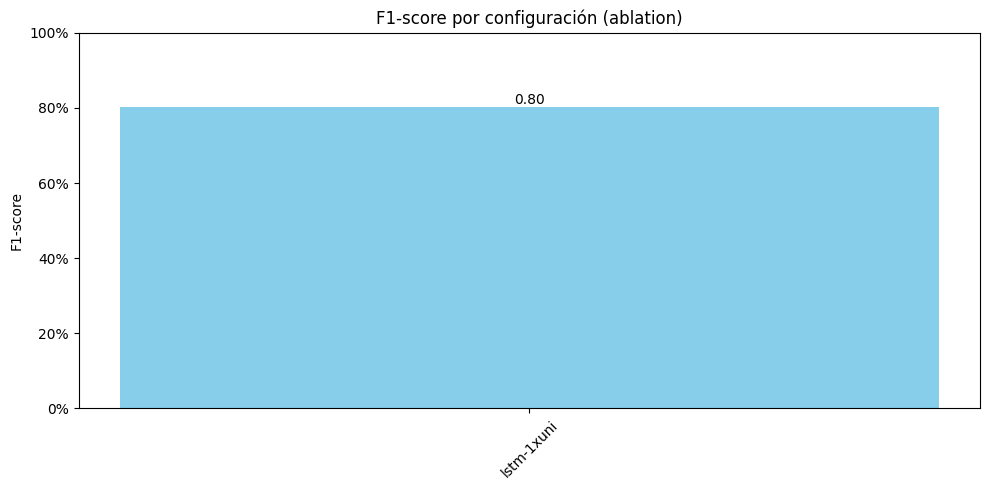

In [69]:
pipeline.visualize_ablation_results(results_3)

Evaluating on device: cuda
              precision    recall  f1-score   support

         0.0       0.91      0.84      0.88     19815
         1.0       0.85      0.92      0.89     19908

    accuracy                           0.88     39723
   macro avg       0.88      0.88      0.88     39723
weighted avg       0.88      0.88      0.88     39723



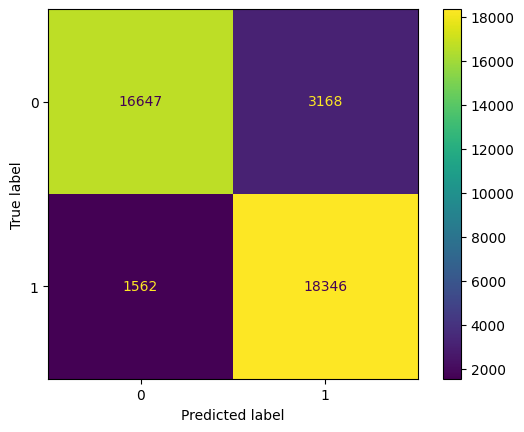

In [70]:
pipeline.evaluate_with_confusion(val_dataset)

# Arquitectura 4 - LSTM - layers-2 - Bidirectional - Optimal Hidden Units

In [71]:
search_space = {
    "hidden_dim": best_params['hidden_dim'],
    "lr": best_params['lr'],
    "freeze": best_params['freeze']
}

In [72]:
ablated_archs = [
        {"rnn_type": "lstm", "num_layers": 2, "bidirectional": True}
    ]

In [73]:
pipeline = SentimentPipeline(
    w2v_model=w2v,
    embedding_dim=100,
    search_space=search_space,
    default_archs=ablated_archs,
    default_hparams={"n_trials": 2, "epochs": 5, "batch_size": 4}
)

results_4 = pipeline.run_ablation(df,configs=ablated_archs)


Running Ablation:   0%|          | 0/1 [00:00<?, ?it/s]


Testing config: {'rnn_type': 'lstm', 'num_layers': 2, 'bidirectional': True}
Training on device: cuda
Epoch 1 | Loss: 8285.4175 | Accuracy: 0.74
Epoch 2 | Loss: 6712.8633 | Accuracy: 0.80
Epoch 3 | Loss: 5759.2880 | Accuracy: 0.84
Epoch 4 | Loss: 4756.6365 | Accuracy: 0.87
Epoch 5 | Loss: 3630.2589 | Accuracy: 0.91
Evaluating on device: cuda


Running Ablation: 100%|██████████| 1/1 [05:17<00:00, 317.07s/it]

Accuracy:  0.80
Precision: 0.78
Recall:    0.84
F1-score:  0.81


In [74]:
model4 = pipeline.model

In [75]:
model4

SentimentRNN(
  RNN(hidden_dim=74, bidirectional=True)
  (embedding): Embedding(128180, 100)
  (rnn): LSTM(100, 74, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=148, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [76]:
print("\nResumen de resultados 4a arquitectura:")
for r in results_4:
    print(r)


Resumen de resultados 4a arquitectura:
{'config': {'rnn_type': 'lstm', 'num_layers': 2, 'bidirectional': True}, 'accuracy': 0.7997482693517936, 'precision': 0.7769284225156359, 'recall': 0.8422903063787042, 'f1': 0.8082901554404145}


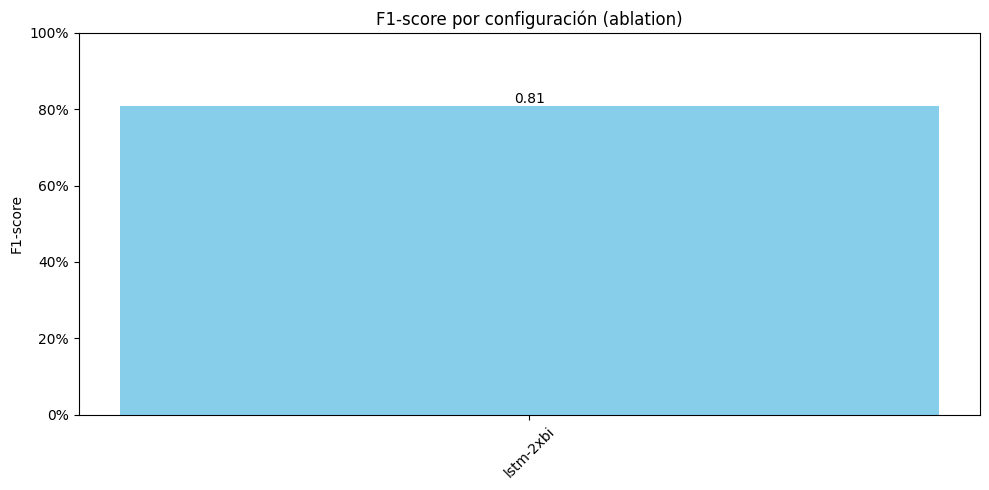

In [77]:
pipeline.visualize_ablation_results(results_4)

Evaluating on device: cuda
              precision    recall  f1-score   support

         0.0       0.94      0.90      0.92     19815
         1.0       0.91      0.94      0.92     19908

    accuracy                           0.92     39723
   macro avg       0.92      0.92      0.92     39723
weighted avg       0.92      0.92      0.92     39723



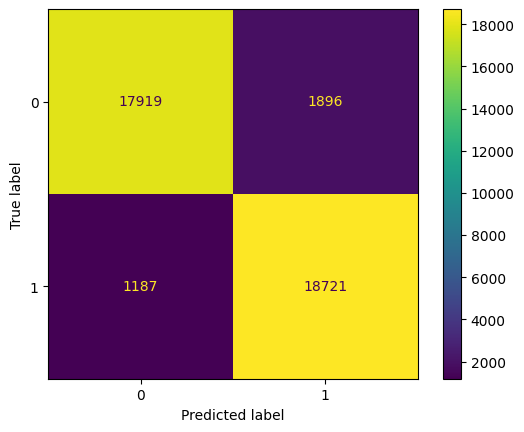

In [78]:
pipeline.evaluate_with_confusion(val_dataset)

# Arquitectura 5 - GRU- layers-2- Bidirectional - Optimal Hidden Units

In [79]:
ablated_archs = [
        {"rnn_type": "gru", "num_layers": 2, "bidirectional": True},
    ]

In [80]:
search_space = {
    "hidden_dim": best_params['hidden_dim'],
    "lr": best_params['lr'],
    "freeze": best_params['freeze']
}

pipeline = SentimentPipeline(
    w2v_model=w2v,
    embedding_dim=100,
    search_space=search_space,
    default_archs=ablated_archs,
    default_hparams={"n_trials": 2, "epochs": 5, "batch_size": 4}
)

results_5 = pipeline.run_ablation(df,configs=ablated_archs)  # usa todo lo parametrizado

Running Ablation:   0%|          | 0/1 [00:00<?, ?it/s]


Testing config: {'rnn_type': 'gru', 'num_layers': 2, 'bidirectional': True}
Training on device: cuda
Epoch 1 | Loss: 7621.0657 | Accuracy: 0.77
Epoch 2 | Loss: 6328.8100 | Accuracy: 0.82
Epoch 3 | Loss: 5365.6488 | Accuracy: 0.85
Epoch 4 | Loss: 4211.2061 | Accuracy: 0.89
Epoch 5 | Loss: 3150.5237 | Accuracy: 0.92
Evaluating on device: cuda


Running Ablation: 100%|██████████| 1/1 [04:54<00:00, 294.01s/it]

Accuracy:  0.80
Precision: 0.83
Recall:    0.75
F1-score:  0.79


In [81]:
model5 = pipeline.model

In [82]:
model5

SentimentRNN(
  RNN(hidden_dim=74, bidirectional=True)
  (embedding): Embedding(128180, 100)
  (rnn): GRU(100, 74, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=148, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [152]:
print("\nResumen de resultados 4a arquitectura:")
for r in results_5:
    print(r)


Resumen de resultados 4a arquitectura:
{'config': {'rnn_type': 'gru', 'num_layers': 2, 'bidirectional': True}, 'accuracy': 0.798237885462555, 'precision': 0.8286819563415309, 'recall': 0.7531391260673028, 'f1': 0.7891066964873042}


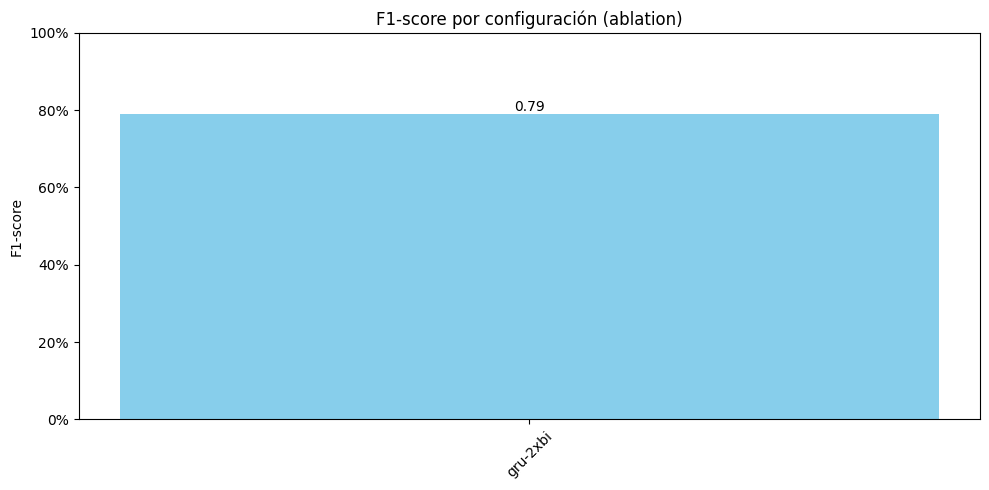

In [153]:
pipeline.visualize_ablation_results(results_5)

Evaluating on device: cuda
              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00     19815
         1.0       0.99      1.00      1.00     19908

    accuracy                           1.00     39723
   macro avg       1.00      1.00      1.00     39723
weighted avg       1.00      1.00      1.00     39723



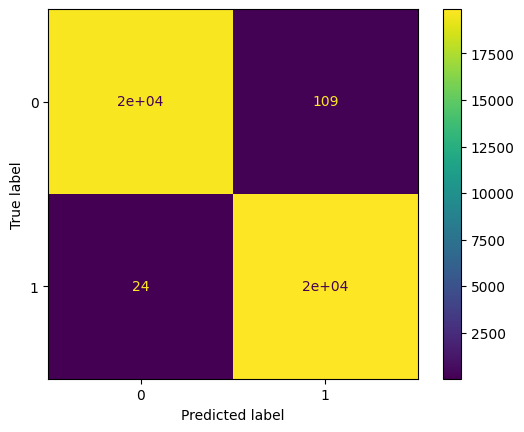

In [154]:
pipeline.evaluate_with_confusion(val_dataset)

# Comparativos de Arquitecturas y Modelos encontrados

In [83]:
data = {
    'Architecture': ['GRU-1xuni', 'GRU-2xuni', 'LSTM-1xuni', 'LSTM-2xuni', 'GRU-2xbi'],
    'F1-score': [results[0]['f1'], results_2[0]['f1'], results_3[0]['f1'], results_4[0]['f1'], results_5[0]['f1']],
    'Accuracy': [results[0]['accuracy'], results_2[0]['accuracy'], results_3[0]['accuracy'], results_4[0]['accuracy'], results_5[0]['accuracy']],
    'Precision': [results[0]['precision'], results_2[0]['precision'], results_3[0]['precision'], results_4[0]['precision'], results_5[0]['precision']],
    'Recall': [results[0]['recall'], results_2[0]['recall'], results_3[0]['recall'], results_4[0]['recall'], results_5[0]['recall']]
}

df_comparison = pd.DataFrame(data)
df_comparison = df_comparison.sort_values(by='F1-score', ascending=False)
display(df_comparison)


,Architecture,F1-score,Accuracy,Precision,Recall
0,GRU-1xuni,0.811615,0.799119,0.765702,0.863385
3,LSTM-2xuni,0.808290,0.799748,0.776928,0.842290
1,GRU-2xuni,0.804132,0.804279,0.806672,0.801607
2,LSTM-1xuni,0.801329,0.789301,0.759676,0.847815
4,GRU-2xbi,0.789107,0.798238,0.828682,0.753139


A continuación, tenemos una gráfica de comparación de resultados, tanto los de la ablación, como los hallados con el pipeline.

Vamos a tener varios subplots con las métricas de cada arquitectura.

<ipython-input-151-9e57d0225477>:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(df_comparison['Architecture'], rotation=45, ha='right')
<ipython-input-151-9e57d0225477>:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(df_comparison['Architecture'], rotation=45, ha='right')
<ipython-input-151-9e57d0225477>:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[2].set_xticklabels(df_comparison['Architecture'], rotation=45, ha='right')
<ipython-input-151-9e57d0225477>:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[3].set_xticklabels(df_comparison['Architecture'], rotation=45, ha='right')


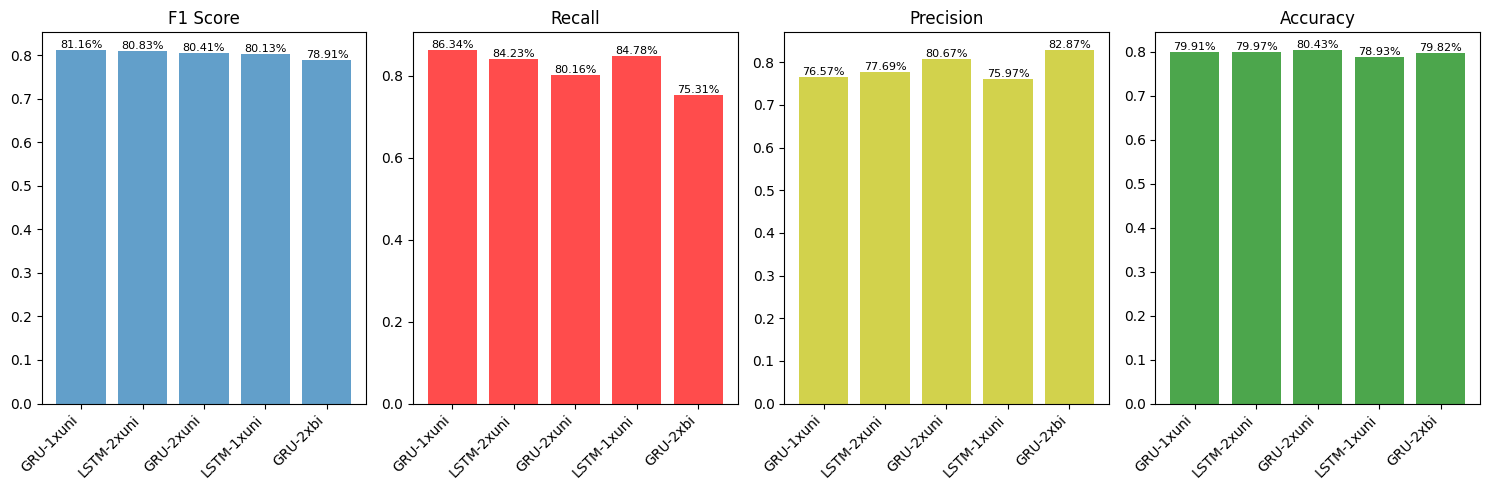

<Figure size 640x480 with 0 Axes>

In [151]:
fig, axs = plt.subplots(1, 4, figsize=(15, 5))


# Plot bar charts for each dataframe
axs[0].bar(df_comparison['Architecture'], df_comparison['F1-score'], alpha=0.7)
axs[0].set_title('F1 Score')
axs[0].set_xticklabels(df_comparison['Architecture'], rotation=45, ha='right')
axs[0].cmap = 'viridis'
for p in axs[0].patches:
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    # Agregar el texto con el valor
    axs[0].annotate(f"{y * 100:.2f}%", (x,y),ha='center', va='bottom', fontsize=8)

axs[1].bar(df_comparison['Architecture'], df_comparison['Recall'], color='r', alpha=0.7)
axs[1].set_title('Recall')
axs[1].set_xticklabels(df_comparison['Architecture'], rotation=45, ha='right')
for p in axs[1].patches:
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    # Agregar el texto con el valor
    axs[1].annotate(f"{y * 100:.2f}%", (x,y),ha='center', va='bottom', fontsize=8)


axs[2].bar(df_comparison['Architecture'], df_comparison['Precision'], color='y', alpha=0.7)
axs[2].set_title('Precision')
axs[2].set_xticklabels(df_comparison['Architecture'], rotation=45, ha='right')
for p in axs[2].patches:
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    # Agregar el texto con el valor
    axs[2].annotate(f"{y * 100:.2f}%", (x,y),ha='center', va='bottom', fontsize=8)


axs[3].bar(df_comparison['Architecture'], df_comparison['Accuracy'], color='g', alpha=0.7)
axs[3].set_title('Accuracy')
axs[3].set_xticklabels(df_comparison['Architecture'], rotation=45, ha='right')
for p in axs[3].patches:
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    # Agregar el texto con el valor
    axs[3].annotate(f"{y * 100:.2f}%", (x,y),ha='center', va='bottom', fontsize=8)



plt.tight_layout()


# Adjust layout and display the plot

plt.show()

plt.savefig('/content/drive/MyDrive/MasterIA/DeepLearning/Microproy2/comparison.png')

Vamos a tener una gráfica más clara que permita comparar los porcentajes de cada una de las métricas para cada arquitectura.

# Una última prueba del Pipeline

Hemos creado un método para reportar los resultados del pipeline automáticamente. Si quisiéramos comparar nuevamente estas arquitecturas, el Pipeline correría la comparación.

Running on device: cuda

Probando configuración: {'rnn_type': 'gru', 'num_layers': 1, 'bidirectional': False, 'hidden_dim': 64, 'lr': 0.001, 'freeze': True}
Training on device: cuda
Epoch 1 | Loss: 3854.6089 | Accuracy: 0.76
Epoch 2 | Loss: 3258.1324 | Accuracy: 0.81
Epoch 3 | Loss: 2928.5598 | Accuracy: 0.83
Evaluating on device: cuda
Accuracy:  0.81
Precision: 0.83
Recall:    0.77
F1-score:  0.80

Probando configuración: {'rnn_type': 'lstm', 'num_layers': 2, 'bidirectional': True, 'hidden_dim': 128, 'lr': 0.0005, 'freeze': False}
Training on device: cuda
Epoch 1 | Loss: 3750.5801 | Accuracy: 0.77
Epoch 2 | Loss: 2406.6121 | Accuracy: 0.87
Epoch 3 | Loss: 1508.0010 | Accuracy: 0.93
Evaluating on device: cuda
Accuracy:  0.81
Precision: 0.83
Recall:    0.78
F1-score:  0.80

Probando configuración: {'rnn_type': 'gru', 'num_layers': 2, 'bidirectional': True, 'hidden_dim': 96, 'lr': 0.0008, 'freeze': True}
Training on device: cuda
Epoch 1 | Loss: 3850.2215 | Accuracy: 0.76
Epoch 2 | Loss: 

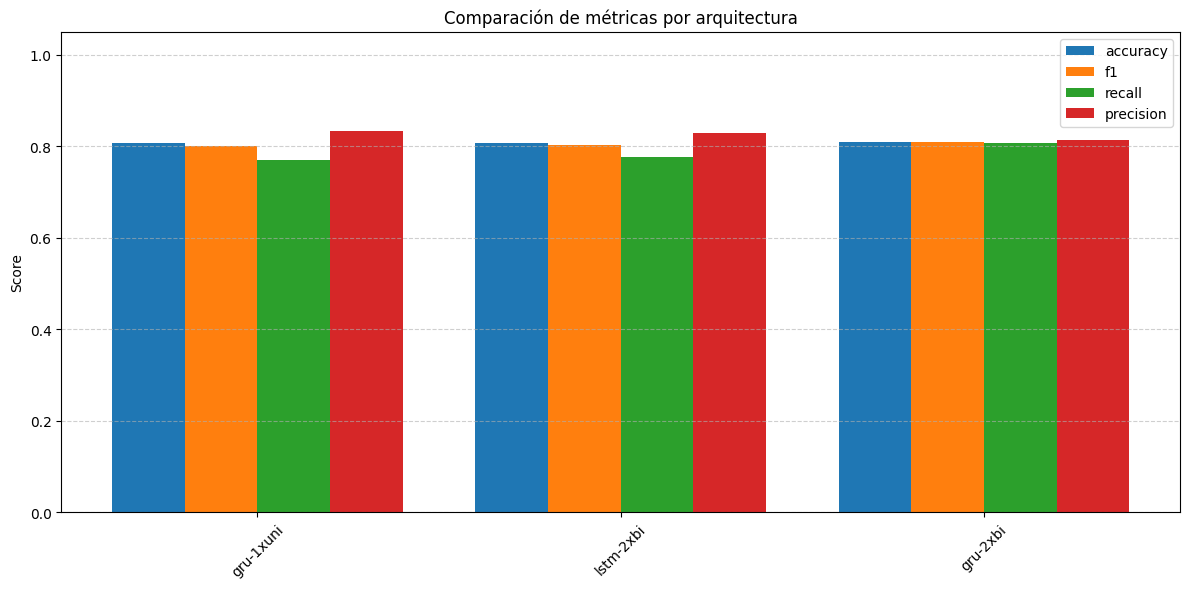

In [88]:
ablated_archs = [
    {"rnn_type": "gru", "num_layers": 1, "bidirectional": False, "hidden_dim": 64, "lr": 0.001, "freeze": True},
    {"rnn_type": "lstm", "num_layers": 2, "bidirectional": True, "hidden_dim": 128, "lr": 0.0005, "freeze": False},
    {"rnn_type": "gru", "num_layers": 2, "bidirectional": True, "hidden_dim": 96, "lr": 0.0008, "freeze": True}
]

summary = pipeline.run_and_compare(df, configs=ablated_archs)


In [89]:
summary

{'results': [{'accuracy': 0.8076777847702958,
   'precision': 0.8330618892508144,
   'recall': 0.7707182320441989,
   'f1': 0.8006783198539004,
   'config': {'rnn_type': 'gru',
    'num_layers': 1,
    'bidirectional': False,
    'hidden_dim': 64,
    'lr': 0.001,
    'freeze': True}},
  {'accuracy': 0.8075519194461925,
   'precision': 0.8287322433663897,
   'recall': 0.7764942240080361,
   'f1': 0.8017632568391028,
   'config': {'rnn_type': 'lstm',
    'num_layers': 2,
    'bidirectional': True,
    'hidden_dim': 128,
    'lr': 0.0005,
    'freeze': False}},
  {'accuracy': 0.8096916299559471,
   'precision': 0.8126582278481013,
   'recall': 0.8061275740833752,
   'f1': 0.8093797276853253,
   'config': {'rnn_type': 'gru',
    'num_layers': 2,
    'bidirectional': True,
    'hidden_dim': 96,
    'lr': 0.0008,
    'freeze': True}}],
 'best_model': SentimentRNN(
   RNN(hidden_dim=96, bidirectional=True)
   (embedding): Embedding(128180, 100)
   (rnn): GRU(100, 96, num_layers=2, batch_firs

In [ ]:
mejor_modelo = summary["best_model"]

In [ ]:
summary

In [90]:
df_results = pd.DataFrame(summary["results"])
df_results

,accuracy,precision,recall,f1,config
0,0.807678,0.833062,0.770718,0.800678,"{'rnn_type': 'gru', 'num_layers': 1, 'bidirect..."
1,0.807552,0.828732,0.776494,0.801763,"{'rnn_type': 'lstm', 'num_layers': 2, 'bidirec..."
2,0.809692,0.812658,0.806128,0.809380,"{'rnn_type': 'gru', 'num_layers': 2, 'bidirect..."


In [167]:
import matplotlib.cm as cm
from matplotlib.patches import Patch

<ipython-input-174-d0e751fbc4c6>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10', num_configs)(np.arange(num_configs))


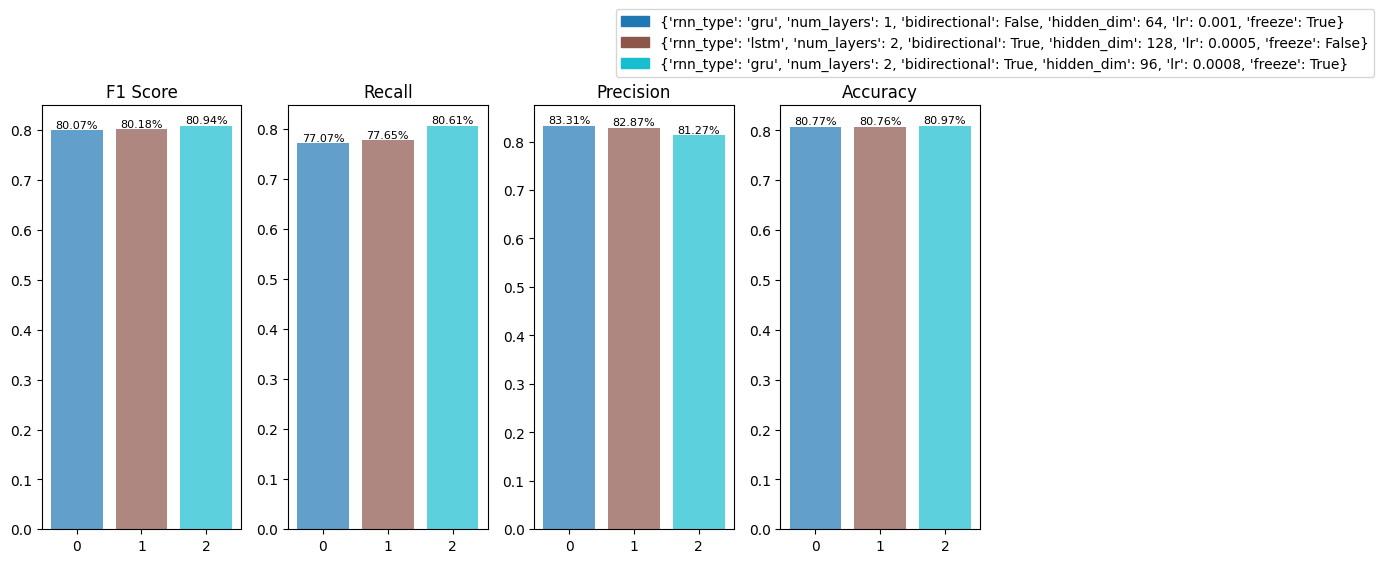

In [174]:
fig, axs = plt.subplots(1, 4, figsize=(10,5 ))

configs = df_results['config']
num_configs = len(configs)
colors = cm.get_cmap('tab10', num_configs)(np.arange(num_configs))

axs[0].bar(df_results.index, df_results['f1'], alpha=0.7, color=colors)
axs[0].set_title('F1 Score')
#axs[0].set_xticklabels(df_results['config'], rotation=45, ha='right')
for p in axs[0].patches:
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()

    axs[0].annotate(f"{y * 100:.2f}%", (x,y),ha='center', va='bottom', fontsize=8)

axs[1].bar(df_results.index, df_results['recall'], alpha=0.7,color=colors)
axs[1].set_title('Recall')
#axs[1].set_xticklabels(df_results['config'], rotation=45, ha='right')
for p in axs[1].patches:
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    axs[1].annotate(f"{y * 100:.2f}%", (x,y),ha='center', va='bottom', fontsize=8)

axs[2].bar(df_results.index, df_results['precision'], alpha=0.7,color=colors)
axs[2].set_title('Precision')
#axs[2].set_xticklabels(df_results['config'], rotation=45, ha='right')
for p in axs[2].patches:
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    axs[2].annotate(f"{y * 100:.2f}%", (x,y),ha='center', va='bottom', fontsize=8)

axs[3].bar(df_results.index, df_results['accuracy'], alpha=0.7,color=colors)
axs[3].set_title('Accuracy')
#axs[3].set_xticklabels(df_results['config'], rotation=45, ha='right')
for p in axs[3].patches:
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    axs[3].annotate(f"{y * 100:.2f}%", (x,y),ha='center', va='bottom', fontsize=8)

legend_patches = [
    Patch(color=colors[i], label=configs.iloc[i])
    for i in range(num_configs)
]

fig.legend(handles=legend_patches, loc='center',
           ncol=1, bbox_to_anchor=(1, 1.05))
plt.tight_layout()


plt.show()



# Entrenando el mejor modelo

In [101]:
pipeline.model = mejor_modelo

In [102]:
df = imdb_df.copy()

In [103]:
# 1. Asegurarse de tener datos de entrenamiento preprocesados
df_train = pipeline.preprocess_and_tokenize(df, build_vocab=True)
train_dataset = pipeline.create_dataset(df_train)

In [104]:
# 2. Obtener la mejor configuración encontrada previamente
#cfg =pipeline. best_params
cfg = best_params



In [105]:
mejor_modelo

SentimentRNN(
  RNN(hidden_dim=74, bidirectional=True)
  (embedding): Embedding(145675, 100)
  (rnn): GRU(100, 74, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=148, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

Ya que encontramos el mejor modelo,vamos a entrenarlo por 6 épocas  esto nos debe garantizar un buen desempeño.

In [107]:
# 3. Entrenar el modelo usando esa configuración, pero con 10 épocas
trained_model = pipeline.train(
    train_dataset,
    hidden_dim=best_params['hidden_dim'],
    lr=best_params["lr"],
    freeze=best_params["freeze"],
    epochs=6,  # Número de épocas ajustado
    num_layers=2,
    bidirectional=True,
    rnn_type='lstm',
    batch_size=4
)

Training on device: cuda
Epoch 1 | Loss: 4317.9807 | Accuracy: 0.80
Epoch 2 | Loss: 2669.3661 | Accuracy: 0.89
Epoch 3 | Loss: 1559.9104 | Accuracy: 0.94
Epoch 4 | Loss: 748.1916 | Accuracy: 0.97
Epoch 5 | Loss: 294.3032 | Accuracy: 0.99
Epoch 6 | Loss: 101.1288 | Accuracy: 1.00


Evaluating on device: cuda
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     19815
         1.0       1.00      1.00      1.00     19908

    accuracy                           1.00     39723
   macro avg       1.00      1.00      1.00     39723
weighted avg       1.00      1.00      1.00     39723



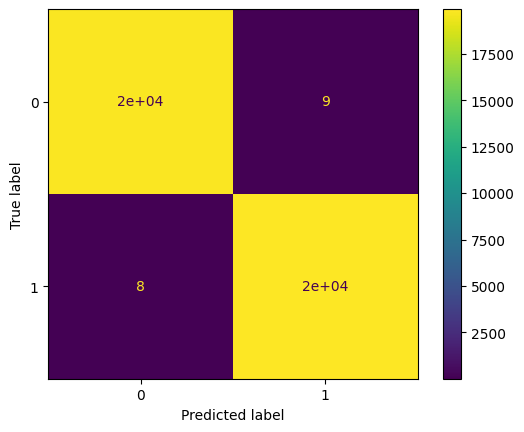

In [139]:
pipeline.evaluate_with_confusion(train_dataset)

In [140]:
df_results = pd.DataFrame(summary["results"])
df_results["config_str"] = df_results["config"].apply(
    lambda cfg: f"{cfg['rnn_type']}-{cfg['num_layers']}x{'bi' if cfg['bidirectional'] else 'uni'}"
)

df_results.to_csv("comparacion_modelos.csv", index=False)
print(" Resultados exportados a comparacion_modelos.csv")

 Resultados exportados a comparacion_modelos.csv


In [141]:
!pip freeze > '/content/drive/MyDrive/MasterIA/DeepLearning/Microproy2/requirements.txt'

# Resultados y Conclusiones



1.   **Incidencia de los hiperparámetros**: En la primera parte de este notebook corrimos una optimización de hiperparámetros sobre una arquitectura fija. Pudimos obtener una buen desempeño del modelo, sin embargo esta optimización no nos dio información sobre cómo se comportaba la arquitectura RNN y sus tipos, capas escondidas, bidireccionalidad, etc.
2.   **Incidencia de la Arquitectura**: En cuanto a la información de cada arquitectura, cada ablación que hicimos paso a paso nos mostró que el
3.   **Ayuda de Optuna**
4.   **Ventajas y Desventajas de utilizar RNN para Análisis de sentimiento**



# Creando una aplicación con Gradio para Análisis de Sentimiento para Reviews de Películas

In [142]:
!pip install gradio

In [143]:
import gradio

In [144]:
gradio.Interface(fn=pipeline.predict, inputs="text", outputs="text").launch(debug=True,share=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://8a10b1410421c9e8e0.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Predicting on device: cuda
Predicting on device: cuda
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://8a10b1410421c9e8e0.gradio.live
